# Transcription Factor Activities - How to score & interpret
**author**: "Marc Elosua Bayes" \
**date**: "09/01/2023"

## Introduction

scRNA-seq data returns individual molecular reads for each cell representing the expression of each gene in each cell. However,  transcript abundances at the individual gene level can be hard to interpret. Another confounding factor with these readouts is the high sparsity of the data. This sparsity acutely affects genes with low mRNA abundance (Figure 1) @mereu2020 . Transcription factors (TFs) are key players involved in regulating the present and future cell states by binding to regulatory regions in the DNA and driving gene expression programs @baskar2022. Therefore, they are tightly regulated and are often found at low abundances due to their powerful effects on the cells. Hence, being able to quantify the activity of TFs in a cell can provide very valuable information when characterizing the biological processes underlying a cell type or state. However, due to their low expression they severely suffer from dropout events and their mRNA abundance can't be accurately quantified by looking at the number of UMIs. To address this issue methods have been developed to quantify their activities by leveraging the expression of the genes they regulate.

<img src="img/mereu-lafzi-dropouts.png" width="900"> \
*Figure 1. Dropout Probability vs Expression level*


In this tutorial we are going to go over the best practices on how to compute these activites, what we need to take into account when computing them and follow a recent benchmarking paper to determine which are the best reference databases @müller-dott2023 and tools to use @badia-i-mompel2022!

Before we start here are some key concepts that will help us and frame the vignette!

-   **What is a transcription factor?**

    Transcription factors are broadly understood as proteins that bind to regulatory regions of the DNA acting as key regulators of gene-expression programs @baskar2022.

-   **What information do we need to compute the activity of a TF?**

    The activity of TF is scored based on the expression of the genes it regulates. Therefore, we need a database that contains which genes are regulated by each transcription factor and the relation between them. Some TF can activate the expression of some genes and repress the expression of others. There are many databases that contain this information and in this vignette we aim to provide the current state of the art databases to use, this can be considered as a gene regulatory network (GRN).

-   **Do transcription factors act the same in all cell types?**

    No! This is crucial to keep in mind when interpreting TF activities. If we take as an example Blimp1 (*PRDM1*) a well characterized TF in B and T cells it has been shown to have very different functions. In B cells, Blimp1 drives plasmablast formation and antibody secretion, whereas in T cells, Blimp1 regulates functional differentiation, including cytokine gene expression. Studies have determined both conserved and unique functions of Blimp1 in different immune cell subsets such as the unique direct activation of the igh gene transcription in B cells and a conserved antagonism with BCL6 in B cells, T cells, and myeloid cells @nadeau2022. This is important to consider because ideally we would have gene-specific GRNs. These can be obtained from multiome datasets but most of the time we don't have this information, hence reference GRNs are available for these cases and this is what is going to be covered in this vignette.

-   **How do we score them in our dataset?**

    There are many ways to score the activation of TFs as shown in the `decoupleR` paper @badia-i-mompel2022. However, they do not all perform the same and it is important to select a robust method. The suggested method after their benchmarking analysis is running a Univariate Linear Model (ULM) where the gene expression values are the response variable and the regulator weights in the gene signature are the explanatory one (don't worry, we'll go through this in more detail in a second). The obtained t-value from the fitted model is the activity score of that gene signature in that cell.

-   **How do we interpret the activity obtained?**

    Scoring gene signatures using Univariate Linear Models and using the resulting t-value as the scoring metric allows us to simultaneously interpret in a single statistic the direction of activity (either + or -) and its significance (the magnitude of the score).

-   **Can we further interrogate the activity scores obtained?**

    Yes! In fact it is very important to look past the score obtained by a cell and into which are the genes driving that activity. Sometimes with TF regulating many genes downstream it could be that just a few genes are contributing to its activity in our dataset. Therefore, if we just stopped at the activity score we could be mislead into thinking that all of the genes downstream of the TF are important when it , usually, is actually only a fraction of them. Moreover, heterogeneous gene expression between two populations can also lead to 2 cells or populations having similar scores for one TF but vastly different genes gene programs underlying them.

## Loading packages

In [41]:
import decoupler as dc

# Only needed for visualization:
from plotnine import *
import scanpy as sc
import random
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

Some settings to use throughout the document

In [42]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=300, facecolor='white', frameon=False)
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

# Set seed for reproducibility
random.seed(10)

scanpy==1.9.5 anndata==0.9.2 umap==0.5.3 numpy==1.24.4 scipy==1.11.2 pandas==2.1.0 scikit-learn==1.3.0 statsmodels==0.14.0 pynndescent==0.5.10


## Load Data

In [43]:
adata = sc.datasets.pbmc3k_processed()

We can visualize the different cell types in it:

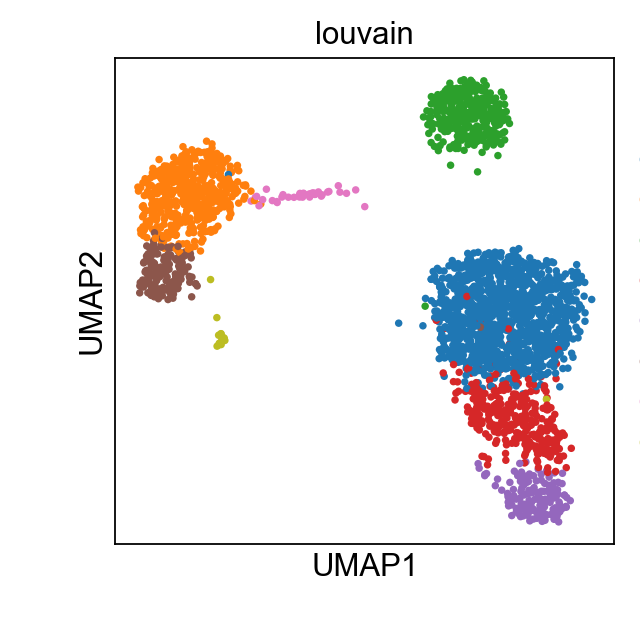

In [44]:
sc.pl.umap(adata, color='louvain')

### TF activity scoring
As mentioned in the introduction we need a GRN specifying the relation between a TF and its downstream genes. A recent benchmark has shown how `CollecTRI` is the best database to estimate TF sctivities @müller-dott2023a. `CollecTRI` contains regulons of signed TF-target genes that have been compiled from 12 different sources, provides increased TF coverage, and in a recent benchmark showed a superior performance in indentifying TF perturbations from gene expression data @müller-dott2023a. You can see the full explanation in the [CollecTRI](https://github.com/saezlab/CollecTRI) gihtub page from the Saez lab. We will also follow the `decoupler` vignette on how to download and score these signatures.

In [45]:
import omnipath

In [46]:
net = dc.get_collectri(organism='human', split_complexes=False)
net

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...
...,...,...,...,...
43173,NFKB,hsa-miR-143-3p,1,19472311
43174,AP1,hsa-miR-206,1,19721712
43175,NFKB,hsa-miR-21-5p,1,20813833;22387281
43176,NFKB,hsa-miR-224-5p,1,23474441;23988648


Note we are using `organism = "human"` since we are working with human data - mouse and rat are also available and `split_complexes=False` since we want to ensure that TF that regulate complexes downstream are scored when the multiple subunits in the complex are present.

In the net dataframe we have the regulation relation between each TF (source) and their downstream genes

In [47]:
# Look at the targets of MYC
df = net[net['source'] == "MYC"]
df

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
146,MYC,EPO,1,10082121
167,MYC,ENO1,1,10823814;11085504;12695333;1451920411085504;14...
274,MYC,CDC25A,1,10205150;11154267;15677471;17671423;8994810;93...
284,MYC,EMP1,1,10207076
...,...,...,...,...
41016,MYC,ATIC,1,18628958
41017,MYC,PFAS,1,18628958
41018,MYC,SERPINI1,1,19442737
41019,MYC,TBX3,1,26266831


In [48]:
# Look at the weights of MYC
print(df['weight'].describe())
print(df['weight'].unique())

count    888.000000
mean       0.810811
std        0.585638
min       -1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: weight, dtype: float64
[ 1 -1]


From here we can gather that in this database MYC is regulating 888 genes-gene complexes. The weight indicates if MYC activates or represses the activity of a genes. Target genes with values > 0 indicate that MYC promotes the expression and viceversa in those with a weight < 1.

It is important to note that here we are using `CollecTRI` as a reference database. Therefore, some TF may be  missing or the mode of regulation may be different from the expected in a cell type of interest. If you have inhouse curated GRNs obtained from inference methods such as CellOracle, pySCENIC or SCENIC+ you can plug them in here. These have the advantage that you can compute GRNs for your cell types and in turn use them in your scRNAseq dataset!

## Activity inference with univariate linear model (ULM)
*"Univariate Linear Model (ULM) fits a linear model for each sample and regulator, where the observed molecular readouts in mat are the response variable and the regulator weights in net are the explanatory one. Target features with no associated weight are set to zero. The obtained t-value from the fitted model is the activity ulm of a given regulator."*

![](img/ulm.png)

Moreover, a nice thing about `ulm` is that in a single statistic it provides the direction of activity (either + or -) and its significance (the magnitude of the score). Making the scores very easy to interpret!

So lets compute the activity scores for every cell in our dataset!

In [49]:
dc.run_ulm(
    mat=adata,
    net=net,
    source='source',
    target='target',
    weight='weight',
    verbose=True
)

1 features of mat are empty, they will be removed.
Running ulm on mat with 2638 samples and 13713 targets for 608 sources.


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


We can access the obtained scores in the .obsm key

In [50]:
print(adata.obsm['ulm_estimate'])
# Looking at all the scores for one specific cell
adata.obsm['ulm_estimate'].loc['AAACATACAACCAC-1']


                      ABL1       AHR      AIRE       AP1     APEX1        AR  \
AAACATACAACCAC-1  3.105525  0.879605  2.909581  3.406139  0.822585  2.255640   
AAACATTGAGCTAC-1  0.644360 -0.912152  0.994977  2.265804  0.947927  1.649978   
AAACATTGATCAGC-1  2.105471  2.411365  2.517760  5.470305  2.126820  3.830119   
AAACCGTGCTTCCG-1  0.276444 -0.050775  3.698970  3.061392  2.169232  4.214352   
AAACCGTGTATGCG-1  2.003764 -0.067381  2.869045  3.876009  2.185390  1.855014   
...                    ...       ...       ...       ...       ...       ...   
TTTCGAACTCTCAT-1  2.286171  1.772632  3.793083  3.976225  1.279274  4.544551   
TTTCTACTGAGGCA-1  2.274256  0.702177  1.214181  2.498602  0.813833  3.195562   
TTTCTACTTCCTCG-1  2.906790  1.537245  2.975046  2.567497  0.765521  1.361371   
TTTGCATGAGAGGC-1 -0.308225  0.795956  2.813365  3.779710  3.331093  0.986313   
TTTGCATGCCTCAC-1  1.273632  0.915997  2.149849  3.688761  1.150695  1.625618   

                    ARID1A    ARID1B   

ABL1       3.105525
AHR        0.879605
AIRE       2.909581
AP1        3.406139
APEX1      0.822585
             ...   
ZNF699    -1.168096
ZNF76      0.816605
ZNF804A   -0.090830
ZNF91      1.496585
ZXDC       2.328759
Name: AAACATACAACCAC-1, Length: 608, dtype: float32

In [51]:
# Save them with a name that indicates the method we obtained them
adata.obsm['collectri_ulm_estimate'] = adata.obsm['ulm_estimate'].copy()
adata.obsm['collectri_ulm_pvals'] = adata.obsm['ulm_pvals'].copy()
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'ulm_estimate', 'ulm_pvals', 'collectri_ulm_estimate', 'collectri_ulm_pvals'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [52]:
# Check if the results are concordant between Python and R 
print(adata.obsm['collectri_ulm_estimate'].loc['TTTGCATGAGAGGC-1'])
print(adata.obsm['collectri_ulm_pvals'].loc['AAGATGGAGATAAG-1'])

ABL1      -0.308225
AHR        0.795956
AIRE       2.813365
AP1        3.779710
APEX1      3.331093
             ...   
ZNF699    -0.308462
ZNF76     -0.132604
ZNF804A   -0.072639
ZNF91      3.547970
ZXDC       1.242560
Name: TTTGCATGAGAGGC-1, Length: 608, dtype: float32
ABL1       9.024132e-01
AHR        2.463379e-01
AIRE       4.796128e-03
AP1        4.613045e-08
APEX1      2.162330e-02
               ...     
ZNF699     8.381944e-01
ZNF76      3.009375e-01
ZNF804A    9.090095e-01
ZNF91      1.617421e-03
ZXDC       2.513558e-01
Name: AAGATGGAGATAAG-1, Length: 608, dtype: float64


We can see how the results maintain the same direction but are slightly different in their magnitude. This can be driven by mainly by the normalization being slightly different between Scanpy and Seurat see more details [here](https://twitter.com/lpachter/status/1694387749967847874).

#### How does a univariate linear model work?
Lets start with a toy example. Imagine a very simple scenario where we have two very simple vectors where one is double the other. We can compute the linear model and also easily visualize the relationship between both vectors:

In [53]:
from scipy.stats import linregress  # Import linregress from scipy.stats
# Define data as a DataFrame
df = pd.DataFrame({'vec1': [1, 2, 5], 'vec2': [2.1, 3.8, 9.7]})
# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(df['vec1'], df['vec2'])

y = 1.92x + 0.09


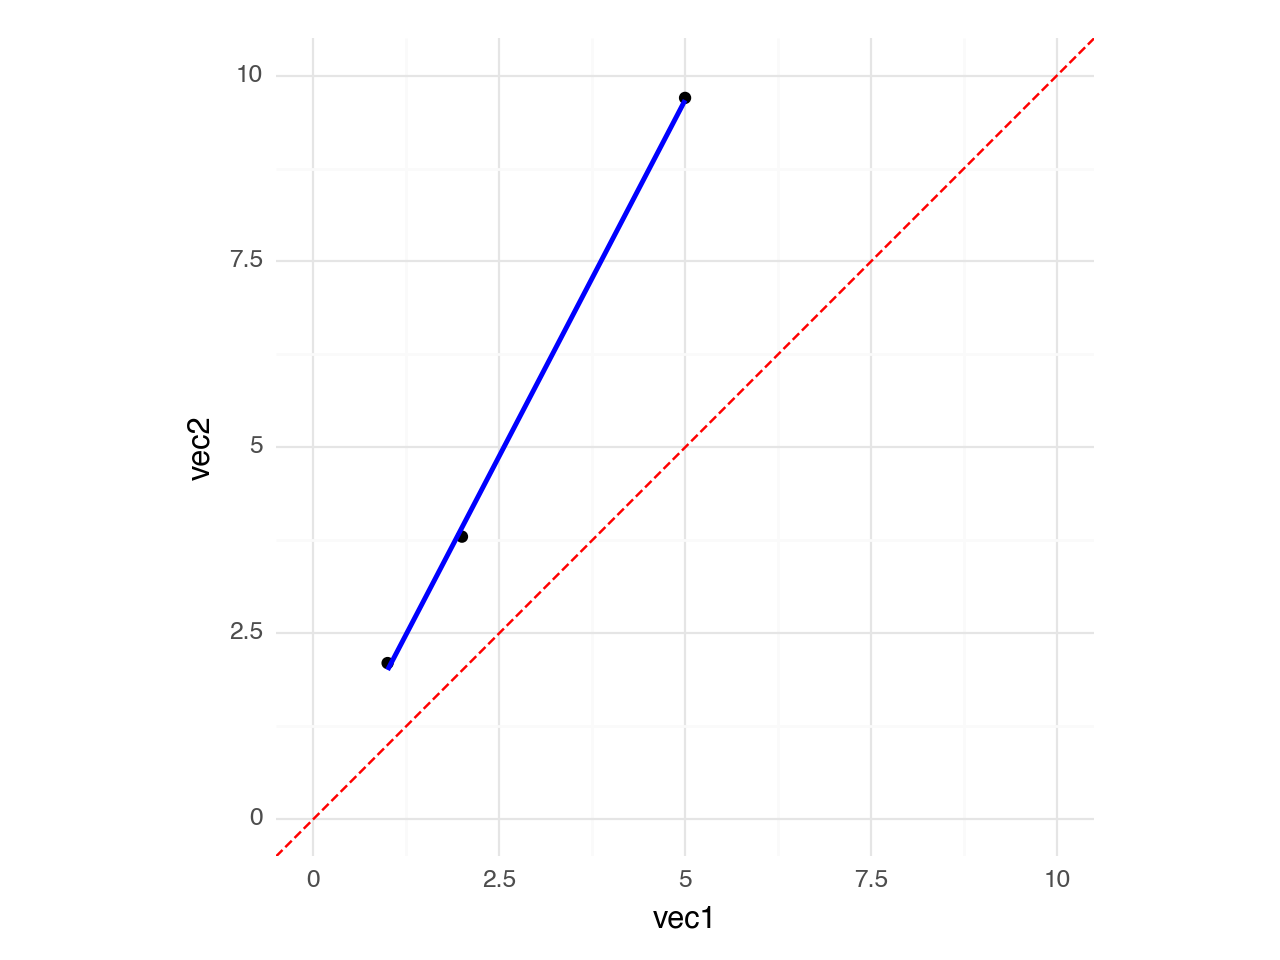

In [54]:
form = f'y = {slope:.2f}x + {intercept:.2f}'
print(form)
# Create the scatter plot with regression line and equation
p = (
    ggplot(df, aes(x='vec1', y='vec2')) +
    geom_point() +
    geom_abline(intercept=0, slope=1, color="red", linetype="dashed") +
    geom_smooth(method='lm', se=False, color='blue', formula='y ~ x') +
    coord_fixed() +
    xlim(0, 10) +
    ylim(0, 10) +
    theme_minimal()
)

print(p)

In the example above we see the linear relationship between both vectors and we get the slope and the T value:\
- The **slope** indicates the what is the change in the response variable (vec2) given a 1 unit change in the predictor variable (vec1).

\- The **T statistic** is the result of a T test. The T test assesses the significance of individual coefficients in our model. The T value indicates the number of standard errors the estimated coefficient is away from the null hypothesis (t = 0). Remember the T value is the $\frac{coefficient}{standard~error}$.

#### Visualization
To visualize the obtained scores, we can re-use many of scanpy’s plotting functions. First though, we need to extract them from the adata object.

In [55]:
acts = dc.get_acts(adata, obsm_key='collectri_ulm_estimate')
acts

AnnData object with n_obs × n_vars = 2638 × 608
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'ulm_estimate', 'ulm_pvals', 'collectri_ulm_estimate', 'collectri_ulm_pvals'

dc.get_acts returns a new AnnData object which holds the obtained activities in its .X attribute, allowing us to re-use many scanpy functions. For example, we can look at the activity of PAX5, a B cell specific TF.

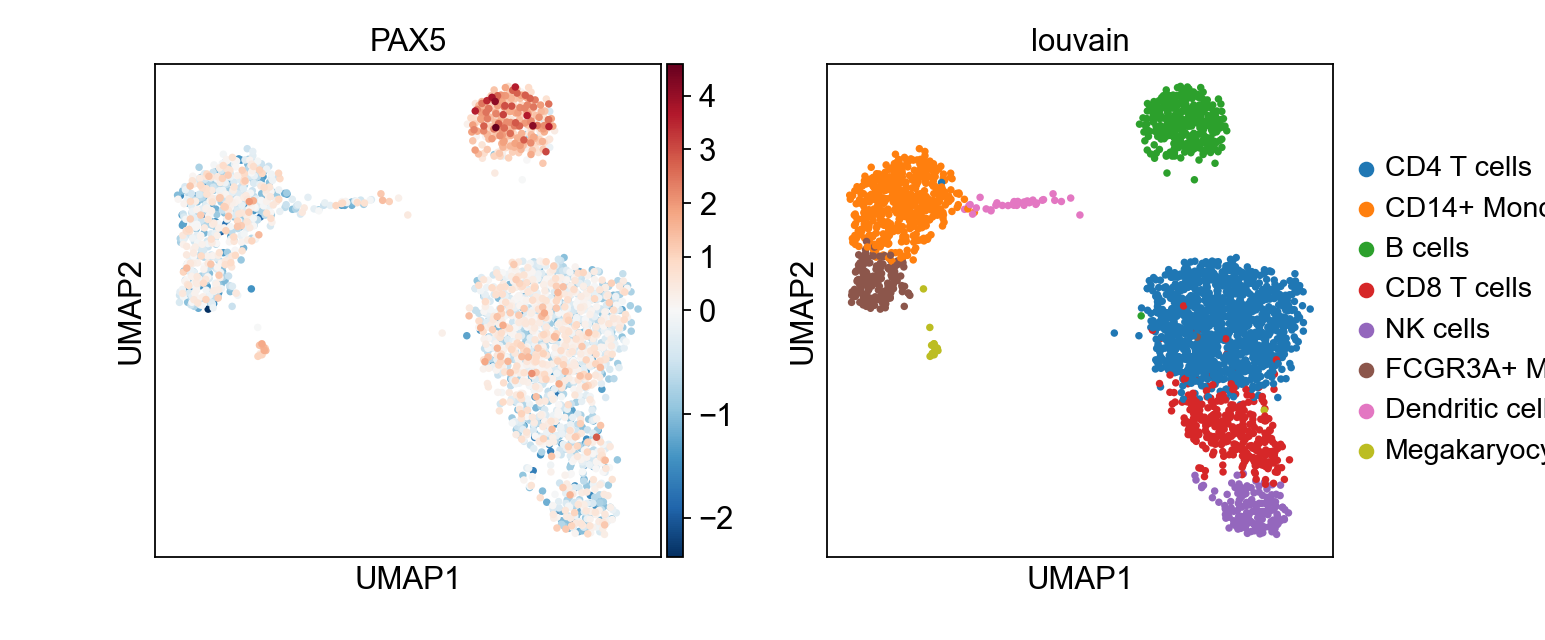

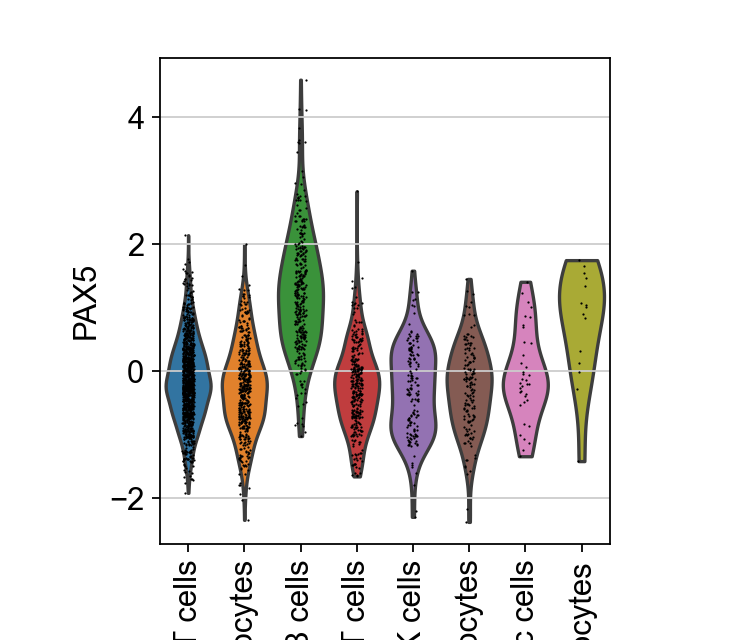

In [56]:
sc.pl.umap(acts, color=['PAX5', 'louvain'], cmap='RdBu_r', vcenter=0)
sc.pl.violin(acts, keys=['PAX5'], groupby='louvain', rotation=90)

As mentioned in the introduction, TF are usually very lowly expressed and thus the mRNAs suffer from higher droput rates than more highly expressed genes with more mRNA copies. Using TF activities showcases how we can recover their activity by looking at the genes a TF regulates downstream.

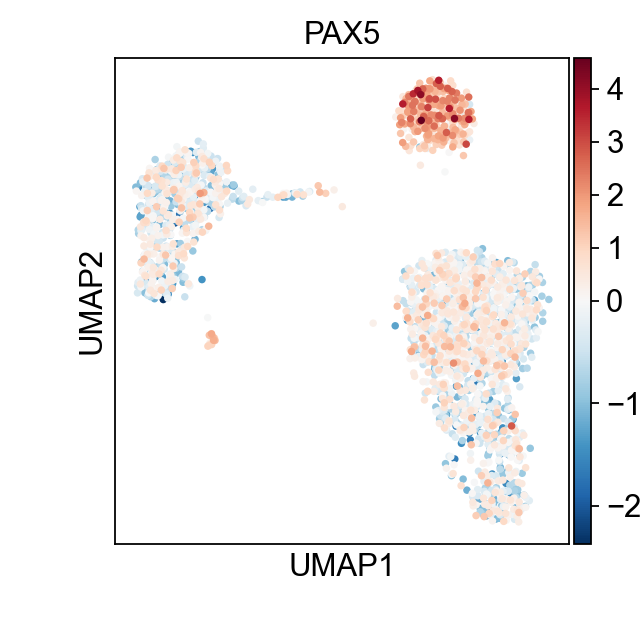

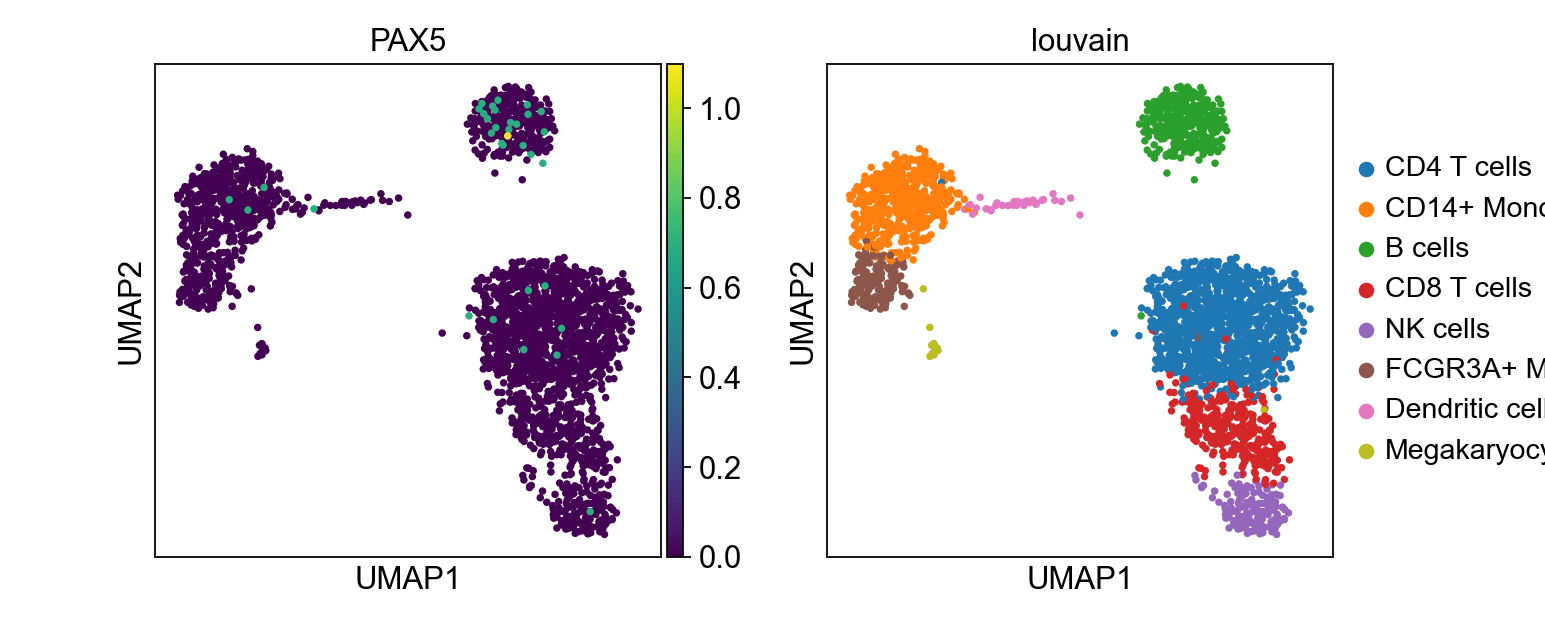

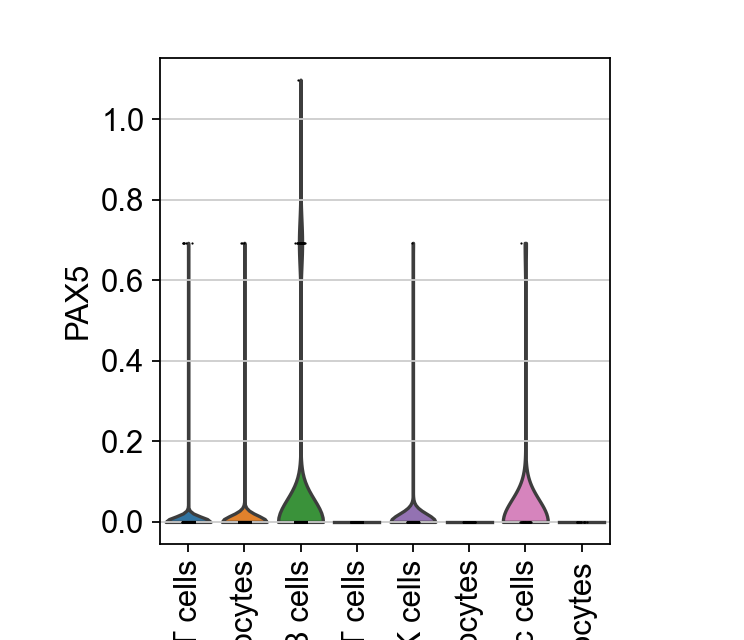

In [57]:
sc.pl.umap(acts, color=['PAX5'], cmap='RdBu_r', vcenter=0)
sc.pl.umap(adata, color=['PAX5', 'louvain'])
sc.pl.violin(adata, keys=['PAX5'], groupby='louvain', rotation=90)

We can clearly observe how the number of PAX5 mRNA captured in our scRNAseq dataset is extremely low and sparse and we cannot be sure that the signal we are seeing is truly biological or just noise.

##### Exploration
(Following the `decoupler` vignette here)
Let’s identify which are the top TF per cell type. We can do it by using the function dc.rank_sources_groups, which identifies marker TFs using the same statistical tests available in scanpy’s scanpy.tl.rank_genes_groups. This extracts the top 3 markers per cell type

In [58]:
df = dc.rank_sources_groups(acts, groupby='louvain', reference='rest', method='t-test_overestim_var')
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,B cells,rest,EBF1,46.169802,2.599989,7.606312e-180,1.156159e-177
1,B cells,rest,RFXANK,41.651197,10.032308,1.121618e-186,6.819437e-184
2,B cells,rest,RFXAP,41.465617,10.624727,1.992501e-185,4.038135e-183
3,B cells,rest,RFX5,41.407184,8.863535,1.182168e-185,3.593792e-183
4,B cells,rest,CIITA,38.505628,6.445230,7.547885e-173,9.178228e-171
...,...,...,...,...,...,...,...
4859,NK cells,rest,TGFB1I1,-11.229042,-1.846321,1.388053e-24,4.219683e-23
4860,NK cells,rest,HMGA2,-11.360328,-1.685326,5.053315e-25,1.706897e-23
4861,NK cells,rest,MYC,-11.377915,-2.238804,6.109869e-25,1.955158e-23
4862,NK cells,rest,THRA,-11.795926,-1.196717,2.315020e-26,8.797074e-25


In [59]:
n_markers = 3
source_markers = df.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
source_markers

{'B cells': ['EBF1', 'RFXANK', 'RFXAP'],
 'CD14+ Monocytes': ['ONECUT1', 'EHF', 'ELF3'],
 'CD4 T cells': ['ZBTB4', 'MYC', 'ZBED1'],
 'CD8 T cells': ['KLF13', 'NFKB2', 'RELB'],
 'Dendritic cells': ['RFXAP', 'RFXANK', 'RFX5'],
 'FCGR3A+ Monocytes': ['SIN3A', 'PPARD', 'SPIC'],
 'Megakaryocytes': ['PKNOX1', 'PBX2', 'FLI1'],
 'NK cells': ['ZGLP1', 'CEBPZ', 'ZNF395']}

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_louvain']`


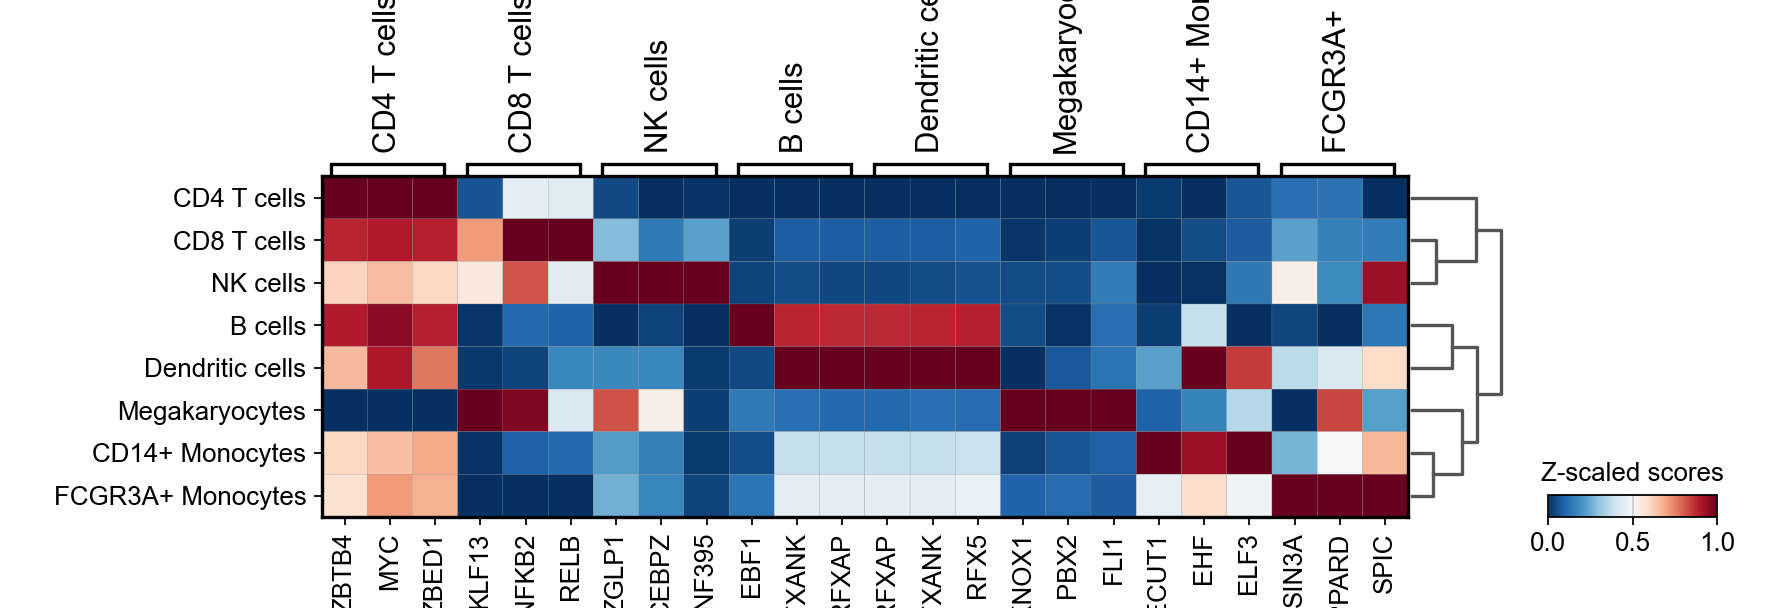

In [60]:
sc.pl.matrixplot(acts, source_markers, 'louvain', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

In [61]:
import session_info
session_info.show(html=False, dependencies=True)

-----
anndata             0.9.2
decoupler           1.5.0
omnipath            1.0.7
pandas              2.1.0
plotnine            0.12.3
scanpy              1.9.5
scipy               1.11.2
session_info        1.0.0
-----
CoreFoundation              NA
Foundation                  NA
PIL                         10.0.0
PyObjCTools                 NA
annotated_types             0.5.0
anyio                       NA
appnope                     0.1.3
arrow                       1.2.3
asttokens                   NA
attr                        23.1.0
attrs                       23.1.0
babel                       2.12.1
backcall                    0.2.0
brotli                      1.1.0
certifi                     2023.07.22
cffi                        1.15.1
charset_normalizer          3.2.0
colorama                    0.4.6
comm                        0.1.4
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.7.0
dec

# References
- Badia-i-Mompel, Pau, Jesús Vélez Santiago, Jana Braunger, Celina Geiss, Daniel Dimitrov, Sophia Müller-Dott, Petr Taus, et al. 2022. “decoupleR: Ensemble of Computational Methods to Infer Biological Activities from Omics Data.” Edited by Marieke Lydia Kuijjer. Bioinformatics Advances 2 (1). https://doi.org/10.1093/bioadv/vbac016. \
- Baskar, Reema, Amy F. Chen, Patricia Favaro, Warren Reynolds, Fabian Mueller, Luciene Borges, Sizun Jiang, et al. 2022. “Integrating Transcription-Factor Abundance with Chromatin Accessibility in Human Erythroid Lineage Commitment.” Cell Reports Methods 2 (3): 100188. https://doi.org/10.1016/j.crmeth.2022.100188. \
- Mereu, Elisabetta, Atefeh Lafzi, Catia Moutinho, Christoph Ziegenhain, Davis J. McCarthy, Adrián Álvarez-Varela, Eduard Batlle, et al. 2020. “Benchmarking Single-Cell RNA-Sequencing Protocols for Cell Atlas Projects.” Nature Biotechnology 38 (6): 747–55. https://doi.org/10.1038/s41587-020-0469-4. \
- Müller-Dott, Sophia, Eirini Tsirvouli, Miguel Vázquez, Ricardo O. Ramirez Flores, Pau Badia-i-Mompel, Robin Fallegger, Astrid Lægreid, and Julio Saez-Rodriguez. 2023a. “Expanding the Coverage of Regulons from High-Confidence Prior Knowledge for Accurate Estimation of Transcription Factor Activities.” http://dx.doi.org/10.1101/ 2023.03.30.534849. \
- Nadeau, Samantha, and Gislâine A. Martins. 2022. “Conserved and Unique Functions of Blimp1 in Immune Cells.” Frontiers in Immunology 12 (January). https://doi.org/10.3389/fimmu.2021.805260. 